In [1]:
# !pip install wheel==0.38.4
# !pip install setuptools==65
# !pip install gym==0.21
# !pip list

In [2]:
# for saving and training models

loading = True
training = False

In [3]:
from IPython.display import clear_output
from PIL import Image
import matplotlib.pyplot as plt
import gym
import torch
import numpy as np

In [4]:
env = gym.make("ALE/Assault-v5").env

n_actions = env.action_space.n # see more info in actions.txt

print("n_actions=", n_actions)

gym.version.VERSION

n_actions= 7


'0.21.0'

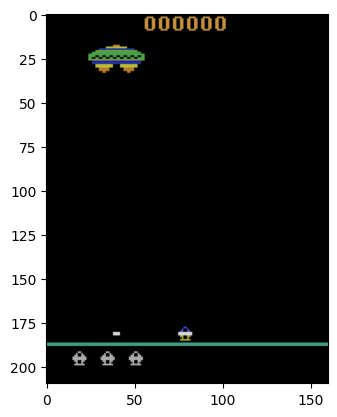

In [5]:
import matplotlib.pyplot as plt

state = env.reset() # state - здесь изображение

height, width, num_channels = state.shape

plt.imshow(state) # здесь можно убрать лишние пиксели, но пока пофиг

Архитектура Нейронной сети

In [6]:
# реализована в файлах Model.py and Agent.py

import Model
from Agent import Agent, get_img_as_tensor

agent = Agent(num_channels=num_channels, height=height, width=width, n_actions=n_actions) 

In [7]:
from PIL import Image 

print(agent.model(get_img_as_tensor(state).unsqueeze(0)))

tensor([[-0.1023,  0.1041, -0.1734, -0.0472, -0.0918,  0.1647, -0.2455]],
       grad_fn=<AddmmBackward0>)


## Функция ошибки!!!!

In [8]:
from IPython.display import clear_output
from tqdm import trange

## get action

In [9]:
# realized in Agent.get_action

In [10]:
cnt = 0
losses = []
L = []

def generate_session(env, agent, t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    state = env.reset()[0]

    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []

    for t in range(t_max):
        action = agent.get_action(state, epsilon=epsilon)

        next_state, reward, done, truncated, _ = env.step(action)

        done = done or truncated
     
        if train:
            states.append(get_img_as_tensor(state))
            actions.append(action)
            rewards.append(reward)
            next_states.append(get_img_as_tensor(next_state))
            dones.append(done)
            # compute_td_loss(model, get_img_as_tensor(state).unsqueeze(0), [action], [reward], get_img_as_tensor(next_state).unsqueeze(0), [done]).backward()

            # opt.step()

        total_reward += reward
        state = next_state
        if done:
            break
    
    states = torch.stack(states, dim=0)
    next_states = torch.stack(next_states, dim=0)
    # print(torch.stack(states))
    
    L.append(agent.step(states, actions, rewards, next_states, dones).detach().numpy())
    
    return total_reward

Обучение нейронной сети.

In [11]:
from IPython.display import clear_output

import matplotlib.pyplot as plt

x = []
y = []


if loading:
    losses = np.load("loss_mean.npy",allow_pickle=True).tolist()
    y = np.load("reward_mean.npy",allow_pickle=True).tolist()
    x = np.load("log.npy",allow_pickle=True).tolist()
    agent.load()

if training:
    for i in range(1000):
        if i % 2 == 1:
            agent.save()
            np.save("loss_mean.npy", losses)
            np.save("reward_mean.npy", y)
            np.save("log.npy", x)
        
        session_rewards = [generate_session(env=env, agent=agent, epsilon=agent.epsilon, train=True) for _ in trange(10)]
        losses.append(np.mean(L))
        L = []

        clear_output(True)
        print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), agent.epsilon))

        agent.epsilon *= 0.99

        if agent.epsilon < 0.001:
            agent.epsilon = 0.1
        assert agent.epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

        x.append(len(x))
        y.append(np.mean(session_rewards))

        fig, axs = plt.subplots(ncols=2)
        
        axs[0].set_title("Reward")
        axs[0].plot(x, y)

        axs[1].set_title("Loss")
        axs[1].plot(x, losses)

        plt.show()

In [13]:
from visualizing import visualize

# agent.model.parameters
# visualize(agent)

TypeError: AtariEnv.render() missing 1 required positional argument: 'mode'